In [2]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [21]:
folder_dir = './testchien'
data = []
label = []

SIZE = 128
#Nettoyage des données
for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir, folder)):
        if file.endswith("jpg"):
            label.append(folder)
            img = cv2.imread(os.path.join(folder_dir, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (SIZE,SIZE))
            data.append(im)
        else:
            continue

In [22]:
data_arr = np.array(data)
label_arr = np.array(label)

In [23]:
encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y,8)
X = data_arr/255 ##couleur

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
#on sépare notre databse en 2 partie : une partie entrainement de 80% et une partie de test de 20%

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [26]:
#On crée un modèle séquentiel
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (SIZE,SIZE,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Couche de classification
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
#éviter overfiting --> éviter qu'il est trop de chose à prendre
model.add(Dense(8, activation = "softmax"))

In [27]:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [28]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
batch_size=32 #nb images qu'il va prendre par époche
epochs=4
#Tour d'entrainement
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/4
38/38 [==============================] - 38s 992ms/step - loss: 2.0825 - accuracy: 0.1385 - val_loss: 2.0770 - val_accuracy: 0.1589
Epoch 2/4
38/38 [==============================] - 38s 992ms/step - loss: 2.0674 - accuracy: 0.1750 - val_loss: 2.0685 - val_accuracy: 0.1788
Epoch 3/4
38/38 [==============================] - 38s 988ms/step - loss: 2.0637 - accuracy: 0.1575 - val_loss: 2.0651 - val_accuracy: 0.1689
Epoch 4/4
38/38 [==============================] - 38s 989ms/step - loss: 2.0563 - accuracy: 0.1609 - val_loss: 2.0635 - val_accuracy: 0.1788


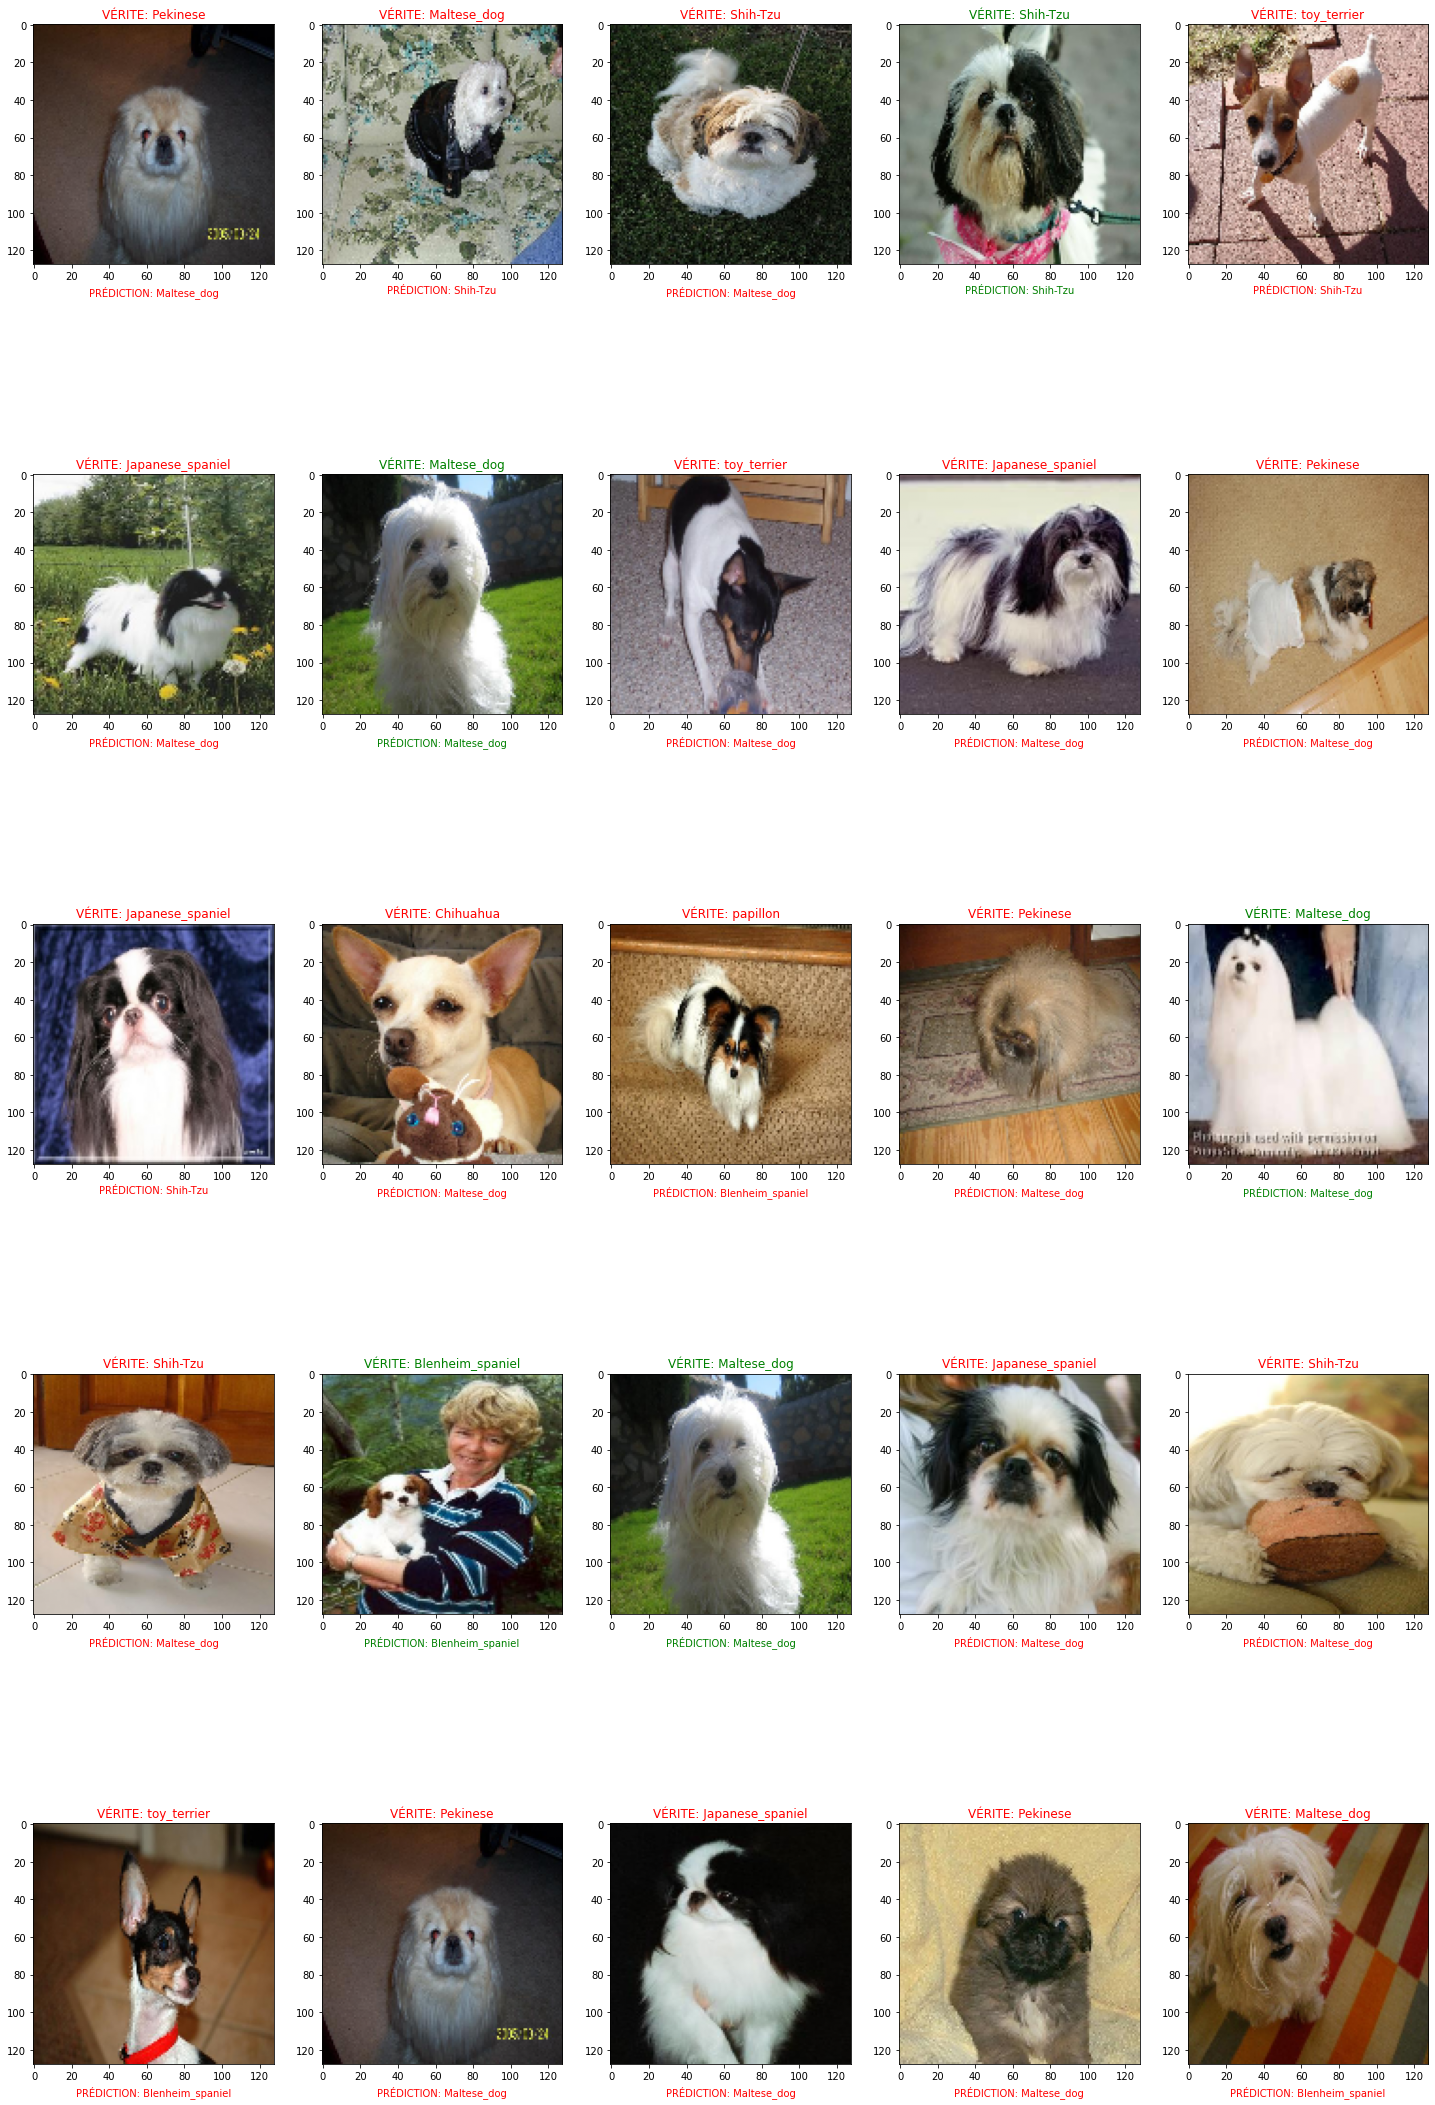

In [29]:
#On teste si le modèle reconnait les données
categories = np.sort(os.listdir(folder_dir))
fig, ax = plt.subplots(5,5, figsize=(25, 40))

for i in range(5):
    for j in range(5):
        k = int(np.random.random_sample() * len(X_test))
        #si la prédiction est égale à la vérité
        if(categories[np.argmax(y_test[k])] == categories[np.argmax(model.predict(X_test)[k])]):
            ax[i,j].set_title("VÉRITE: " + categories[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PRÉDICTION: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')
        #sinon c'est que la prédiction est fausse
        else:
            ax[i,j].set_title("VÉRITE: " + categories[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PRÉDICTION: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')